In [10]:
import numpy as np
import pandas as pd

from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
import shap
import eli5
from eli5.sklearn import PermutationImportance

import matplotlib.pyplot as plt

import warnings
import gc
warnings.filterwarnings("ignore")

In [32]:
data = pd.read_csv('../SHAP/Allmerge2.csv', index_col='acc_id')
data= data.drop(columns='Unnamed: 0')
test = pd.read_csv('../SHAP/Allmerge_test_notinlabel.csv', index_col='acc_id')
df = pd.concat([data, test])

In [34]:
df.head()

amount_spent  amount_spent_pmt  boss_monster  class  combat_char_cnt  \
acc_id                                                                         
2           0.000000          0.000000             0     28         0.000000   
5           0.000000          0.000000             9     36         1.587930   
8           0.020310          1.404644             2    485        58.031626   
17          0.070642          0.000000            21     34        21.689681   
20          0.052137          0.896531             8    158        25.515149   

        combat_play_time      death  enchant_count    etc_cnt  etc_cnt_plg  \
acc_id                                                                       
2               0.000000   0.000000            0.0   0.000000     0.000000   
5               5.097608   0.245370            0.0   0.000000     0.814001   
8             136.879854  91.768298            0.0   0.900892    61.354404   
17             65.693573   1.717588            0.0   0.675669    12.514373   
20             66.451919   0.981479            0.0  16.441283    44.409036   

        ...  random_attacker_cnt_plg  random_defender_cnt  \
acc_id  ...                                                 
2       ...                 0.000000             0.000000   
5       ...                 1.936569             0.000000   
8       ...                33.631748             1.183064   
17      ...                 9.230979             2.366129   
20      ...                11.974452             1.183064   

        random_defender_cnt_plg     revive  same_pledge_cnt  \
acc_id                                                        
2                      0.000000   0.000000         0.000000   
5                      0.929907   0.246819         0.000000   
8                     21.745527  92.310423         0.000000   
17                    10.872764   1.727735        12.398273   
20                     6.580883   0.987277         0.000000   

        same_pledge_cnt_plg   solo_exp  survival_time  temp_cnt  temp_cnt_plg  
acc_id                                                                         
2                  0.000000   0.000000           64.0  0.000000      0.000000  
5                  0.000000   2.151033           60.0  0.479728      2.570959  
8                 29.441536  31.424841           64.0  3.837822     92.455650  
17                 1.591434   9.236949           64.0  3.358094     36.784494  
20                11.140041   0.274340           64.0  0.479728     28.379435  

[5 rows x 35 columns]

In [36]:
df.dtypes

amount_spent               float64
amount_spent_pmt           float64
boss_monster                 int64
class                        int64
combat_char_cnt            float64
combat_play_time           float64
death                      float64
enchant_count              float64
etc_cnt                    float64
etc_cnt_plg                float64
exp_recovery               float64
fishing                    float64
game_money_change          float64
level                        int64
non_combat_play_time       float64
npc_kill                   float64
num_opponent               float64
party_exp                  float64
play_char_cnt              float64
playtime                   float64
pledge_cnt                 float64
pledge_combat_cnt          float64
private_shop               float64
quest_exp                  float64
random_attacker_cnt        float64
random_attacker_cnt_plg    float64
random_defender_cnt        float64
random_defender_cnt_plg    float64
revive              

In [37]:
def rmse_expm1(pred, true):
    return -np.sqrt(np.mean((np.expm1(pred)-np.expm1(true))**2))

def evaluate(x_data, y_data):
    model = LGBMRegressor(objective='regression', num_iterations=10**5)
    x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, random_state=0)
    model.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=False)
    val_pred = model.predict(x_val)
    score = rmse_expm1(val_pred, y_val)
    return score

def rfe(x_data, y_data, method, ratio=0.9, min_feats=40):
    feats = x_data.columns.tolist()
    archive = pd.DataFrame(columns=['model', 'n_feats', 'feats', 'score'])
    while True:
        model = LGBMRegressor(objective='regression', num_iterations=10**5)
        x_train, x_val, y_train, y_val = train_test_split(x_data[feats], y_data, random_state=0)
        model.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=False)
        val_pred = model.predict(x_val)
        score = rmse_expm1(val_pred, y_val)
        n_feats = len(feats)
        print(n_feats, score)
        archive = archive.append({'model': model, 'n_feats': n_feats, 'feats': feats, 'score': score}, ignore_index=True)
        if method == 'basic':
            feat_imp = pd.Series(model.feature_importances_, index=feats).sort_values(ascending=False)
        elif method == 'perm':
            perm = PermutationImportance(model, random_state=0).fit(x_val, y_val)
            feat_imp = pd.Series(perm.feature_importances_, index=feats).sort_values(ascending=False)
        elif method == 'shap':
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(x_data[feats])
            feat_imp = pd.Series(np.abs(shap_values).mean(axis=0), index=feats).sort_values(ascending=False)
        next_n_feats = int(n_feats * ratio)
        if next_n_feats < min_feats:
            break
        else:
            feats = feat_imp.iloc[:next_n_feats].index.tolist()
    return archive

feats = [col for col in data.columns if col != 'survival_time']
len(feats) 

34

In [38]:
feats

['class',
 'level',
 'pledge_cnt',
 'random_attacker_cnt',
 'random_defender_cnt',
 'temp_cnt',
 'same_pledge_cnt',
 'etc_cnt',
 'num_opponent',
 'playtime',
 'npc_kill',
 'solo_exp',
 'party_exp',
 'quest_exp',
 'boss_monster',
 'death',
 'revive',
 'exp_recovery',
 'fishing',
 'private_shop',
 'game_money_change',
 'enchant_count',
 'amount_spent_pmt',
 'play_char_cnt',
 'combat_char_cnt',
 'pledge_combat_cnt',
 'random_attacker_cnt_plg',
 'random_defender_cnt_plg',
 'same_pledge_cnt_plg',
 'temp_cnt_plg',
 'etc_cnt_plg',
 'combat_play_time',
 'non_combat_play_time',
 'amount_spent']

In [40]:
model = LGBMRegressor(objective='regression', num_iterations=10**5)
x_data = data[feats]
y_data = data['survival_time']
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, random_state=0)
model.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=False)
val_pred = model.predict(x_val)
score = rmse_expm1(val_pred, y_val)
score

-1.163818497455815e+33

In [41]:
%%time
basic_archive = rfe(x_data, y_data, 'basic')

34 -1.163818497455815e+33
Wall time: 3.13 s


In [43]:
feat_imp = pd.Series(model.feature_importances_, index=feats).sort_values(ascending=False)
for i in range(40, 90, 5):
    print(i, evaluate(data[feat_imp.iloc[:i].index], data['survival_time']))

40 -1.1638184981509059e+33
45 -1.1638184981509059e+33
50 -1.1638184981509059e+33
55 -1.1638184981509059e+33
60 -1.1638184981509059e+33
65 -1.1638184981509059e+33
70 -1.1638184981509059e+33
75 -1.1638184981509059e+33
80 -1.1638184981509059e+33
85 -1.1638184981509059e+33


In [44]:
%%time
perm_archive = rfe(x_data, y_data, 'perm')

34 -1.163818497455815e+33
Wall time: 24.6 s


In [45]:
perm = PermutationImportance(model, random_state=0).fit(x_val, y_val)
perm_feat_imp = pd.Series(perm.feature_importances_, index=feats).sort_values(ascending=False)
eli5.show_weights(perm)

In [47]:
for i in range(40, 90, 5):
    print(i, evaluate(data[perm_feat_imp.iloc[:i].index], data['survival_time']))

40 -1.1638184981509059e+33
45 -1.1638184981509059e+33
50 -1.1638184981509059e+33
55 -1.1638184981509059e+33
60 -1.1638184981509059e+33
65 -1.1638184981509059e+33
70 -1.1638184981509059e+33
75 -1.1638184981509059e+33
80 -1.1638184981509059e+33
85 -1.1638184981509059e+33


In [48]:
%%time
shap_archive = rfe(x_data, y_data, 'shap')

34 -1.163818497455815e+33
Wall time: 36.7 s


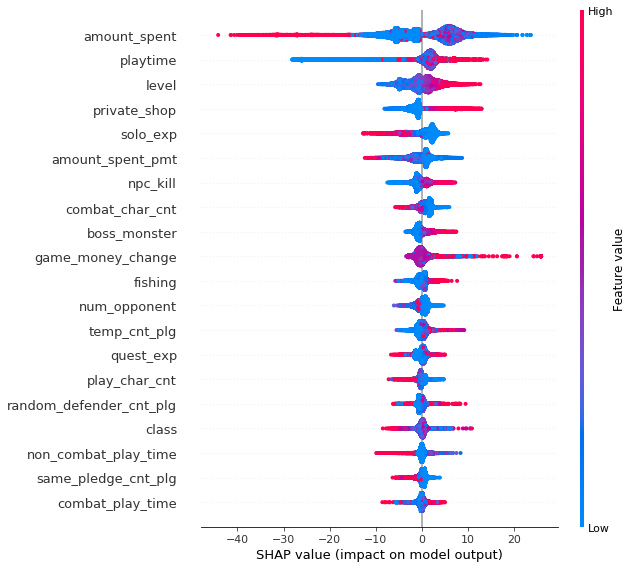

In [49]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_data)
shap_feat_imp = pd.Series(np.abs(shap_values).mean(axis=0), index=feats).sort_values(ascending=False)
shap.summary_plot(shap_values, x_data)

In [51]:
for i in range(40, 90, 5):
    print(i, evaluate(data[shap_feat_imp.iloc[:i].index], data['survival_time']))

40 -1.163818497455815e+33
45 -1.163818497455815e+33
50 -1.163818497455815e+33
55 -1.163818497455815e+33
60 -1.163818497455815e+33
65 -1.163818497455815e+33
70 -1.163818497455815e+33
75 -1.163818497455815e+33
80 -1.163818497455815e+33
85 -1.163818497455815e+33


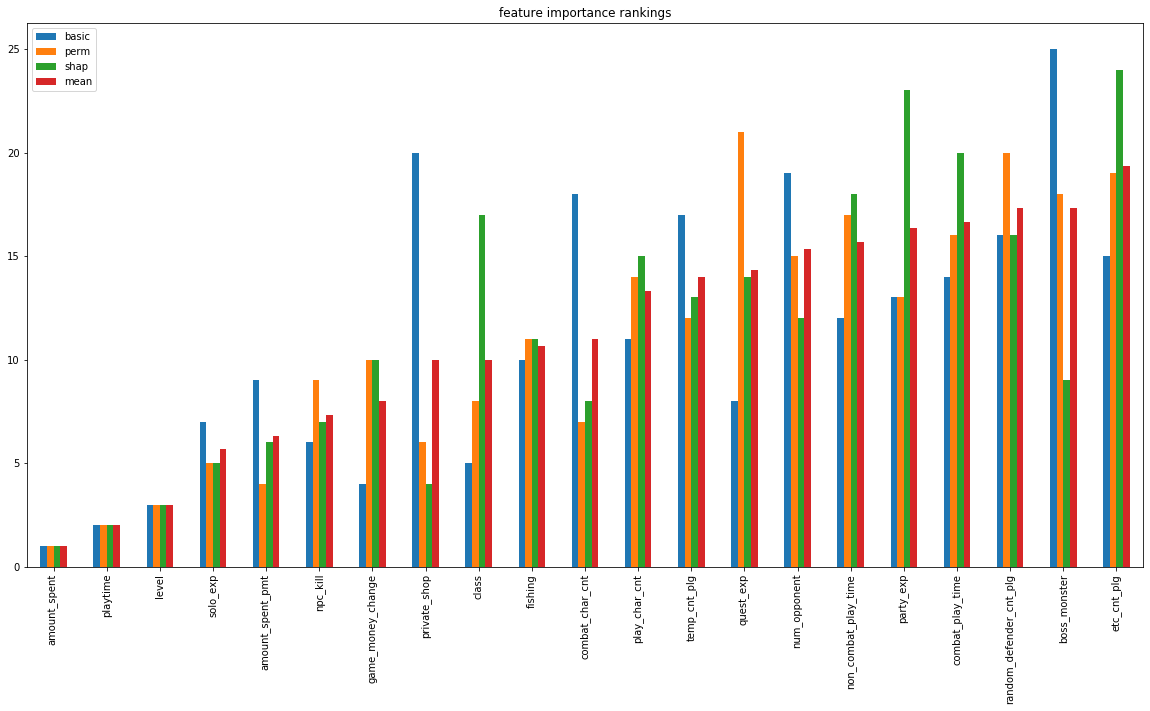

In [52]:
feat_imp_archive = pd.DataFrame(index=feats, columns=['basic', 'perm', 'shap', 'mean'])
feat_imp_archive['basic'] = feat_imp.rank(ascending=False)
feat_imp_archive['perm'] = perm_feat_imp.rank(ascending=False)
feat_imp_archive['shap'] = shap_feat_imp.rank(ascending=False)
feat_imp_archive['mean'] = feat_imp_archive[['basic', 'perm', 'shap']].mean(axis=1)
feat_imp_archive = feat_imp_archive.sort_values('mean')
feat_imp_archive[feat_imp_archive['mean']<20].plot(kind='bar', figsize=(20, 10), title='feature importance rankings');

In [53]:
for i in range(40, 90, 5):
    print(i, evaluate(data[feat_imp_archive.iloc[:i].index], data['survival_time']))

40 -1.1638184981509059e+33
45 -1.1638184981509059e+33
50 -1.1638184981509059e+33
55 -1.1638184981509059e+33
60 -1.1638184981509059e+33
65 -1.1638184981509059e+33
70 -1.1638184981509059e+33
75 -1.1638184981509059e+33
80 -1.1638184981509059e+33
85 -1.1638184981509059e+33


In [55]:
%%time
rf = RandomForestRegressor(n_jobs=-1, n_estimators=200, max_depth=5)
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=0)
feat_selector.fit(data[feats].values, data['survival_time'].values)

Wall time: 11min 10s


BorutaPy(alpha=0.05,
         estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                         max_depth=5, max_features='auto',
                                         max_leaf_nodes=None,
                                         min_impurity_decrease=0.0,
                                         min_impurity_split=None,
                                         min_samples_leaf=1,
                                         min_samples_split=2,
                                         min_weight_fraction_leaf=0.0,
                                         n_estimators=132, n_jobs=-1,
                                         oob_score=False,
                                         random_state=<mtrand.RandomState object at 0x000001BB1C6A5C18>,
                                         verbose=0, warm_start=False),
         max_iter=100, n_estimators='auto', perc=100,
         random_state=<mtrand.RandomState object at 0x000001BB1C6A5C18>,
         

In [62]:
evaluate(data[np.array(feats)[feat_selector.support_]], data['survival_time'])

-2.4669759627157155e+34

In [63]:
# gpu_test.py

import sys
import numpy as np
import tensorflow as tf
from datetime import datetime

shape = (int(10000), int(10000))

# with tf.device("/cpu:0"):
with tf.device("/gpu:0"):
    random_matrix = tf.random_uniform(shape=shape, minval=0, maxval=1)
    dot_operation = tf.matmul(random_matrix, tf.transpose(random_matrix))
    sum_operation = tf.reduce_sum(dot_operation)

startTime = datetime.now()
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
    result = session.run(sum_operation)
    print(result)

print("\n" * 2)
print("Time taken:", datetime.now() - startTime)
print("\n" * 2)

249993080000.0



Time taken: 0:00:02.880938



